When using a neural network, you must split your dataset into two subsets:
    A training set, and
    A test set
Due to the immense number of images required to properly train a neural network and ensure it functions correctly, we will implement a pre-trained neural network. (For demonstration, the code to train the neural network is included anyway, however the final model used is pre-trained).

The use of a vehicle detection method is intended to greater improve the possible use cases of the number plate reader developed previously. Whilst the plate reader works well for a static image of a single car, it will not be able to distinguish multiple numberplates in one image. A vehicle detection neural network will enable this capability.

Vehicles can be detected using a similar method/form of edge detection as in the number plate reader. However, we want to explore different techniques.

The following method requires the purchase of ArcGIS. $100 for a license to use libraries and resources which are commonly freely available:
https://developers.arcgis.com/python/sample-notebooks/vehicle-detection-and-tracking/

https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/
This article will be followed instead.

# Setting up the environment


In [15]:
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import imageio
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import tensorflow as tf # tensorflow ver 1.14.0 is required
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model

# yolo_utils and yad2k are open-source libraries available for implementation at the link below.
# https://github.com/JudasDie/deeplearning.ai/blob/master/Convolutional%20Neural%20Networks/week3/yolo_utils.py
# They are from instructor Andrew Ng on the coursera course, DeepLearning.ai
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Yolo_filter_boxes. This function will filter any yolo prediction boxes by considering a threshold. Any box which predicts a class score or confidence which is lower than the set threshold (we will use 0.6 here), the boc is removed.

In [16]:
# box_confidence - Tensor with shape (19 x 19, 5, 1) containing the confidence probability
# that an object exists in the boxes.
# boxes - Tensor of shape (19 x 19, 5, 4) containing the location of the 5 boxes
# for each cell.
# box_class_probs - Tensor of shape (19 x 19, 5, 80), containing detection
# probabilities for each of the 80 classes.


def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    box_scores = np.multiply(box_confidence, box_class_probs)
    box_classes = K.argmax(box_scores,axis=-1)
    box_class_scores = K.max(box_scores,axis=-1)
    filtering_mask = K.greater_equal(box_class_scores, threshold)
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
 
    return scores, boxes, classes

The iou() and yolo_non_max_suppression implement a non max suppression function. Intersection over Union (IoU) evaluates the area of intersecting predictions (boxes) of the same class, equating those as one prediction and removing the excess.

In [17]:
def iou(box1, box2):
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    box1_area = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area+box2_area-inter_area
    iou = inter_area/union_area
    
    # returns the unionised region of two boxes
 
    return iou

In [18]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    # Initialise a tensor with a max capacity linking to the maximum numebr of boxes to consider
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    # nms_indices - list of indices used to reference the boxes
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold=iou_threshold)
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)

    return scores, boxes, classes

The yolo_eval function takes the output from the yolo model and runs the non-max suppression algorithm on it. Reducing multiple boxes down to a select few with respect to the score threshold and iou threshold.

In [19]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

Next three code blocks included to test the above functions and ensure they are outputting scores, boxes and classes as expected.

In [20]:
yolo_outputs = (tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                   tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                   tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                   tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))

In [21]:
scores, boxes, classes = yolo_eval(yolo_outputs)

In [22]:
with tf.Session() as test_b:
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54


In [23]:
sess = K.get_session()
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
# Set the input image shape which predictions will be scaled up to
image_shape = (720., 1280.)

# Load the YOLO model
yolo_model = load_model("YAD2K-master/model_data/yolov2.h5")

In [24]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [25]:
# Function allows the YOLO model to convert feature tensors of shape (m, 19, 19, 5, 85) to shape (m, 608, 608, 3)
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [26]:
# Using the model output, converted to usable tensors, we can then perform Non-max Suppression
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [27]:
def predict(sess, image_file):
    
    # Resizing the image
    basewidth = 960
    img = Image.open('images/' + image_file)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
    img = img.resize((basewidth, basewidth), PIL.Image.ANTIALIAS)
    img.save('resized_image.jpg')

    # Preprocess your image
    image, image_data = preprocess_image("resized_image.jpg", model_image_size = (608, 608))
    
    #
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    # Print prediction info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    
    
    basewidth = 1280
    hsize = 720
    image = Image.open('images/' + image_file)
    image = img.resize((1280, 720), PIL.Image.ANTIALIAS)
    image = img.resize((1280, 720), PIL.Image.ANTIALIAS)
    
    # Save the predictions as separate image files for plate detection
    for i in range(len(out_boxes)):
        top, left, bottom, right = out_boxes[i]
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        
        print(top, left, (bottom - top), (right - left), image.size)
        cropped_image = tf.image.crop_to_bounding_box(image, top, left,int(bottom - top), int(right - left))
        
        sess = tf.Session()
        img_data = sess.run(cropped_image)
        sess.close()
        
        # Save the detected area as a separate image
        cv2.imwrite(os.path.join('detected/' + str(i) + '_' + image_file), cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR))
    
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 3 boxes for 0ok5hw.jpg
44 44 340 609 (1280, 720)
97 534 520 720 (1280, 720)
2 620 161 585 (1280, 720)
car 0.62 (620, 2) (1205, 163)
truck 0.69 (534, 97) (1254, 617)
car 0.74 (44, 44) (653, 384)


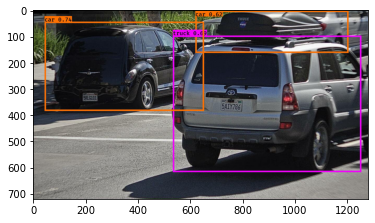

In [28]:
out_scores, out_boxes, out_classes = predict(sess, "0ok5hw.jpg")